# Adınız: Ömer Çağrı
# Soyadınız: Sarıgöl
# Okul Numaranız: 2312721005
# GitHub Repo Bağlantısı: https://github.com/Pasorra/genetik_optimizasyonu

# Genetik Algoritma Optimizasyonu: Kimya Tesisi (Senaryo 5)

## 1. Matematiksel Model

**Amaç Fonksiyonu:**
$$f(x_1, x_2) = 8x_1 + 3x_2 - x_1x_2 + x_1^2$$

**Karar Değişkenleri:**
* $x_1$: Reaksiyon Süresi (dk) $\in [10, 60]$
* $x_2$: Sıcaklık (°C) $\in [40, 120]$

**Sınırlar:**
1.  $g_1(x): x_1 + x_2 \leq 140$
2.  $g_2(x): x_2 \geq 60$ (Bu kısıt, $x_2$'nin alt sınırını efektif olarak 60'a günceller)

**Efektif Sınırlar:**
* $10 \leq x_1 \leq 60$
* $60 \leq x_2 \leq 120$

In [178]:
import numpy as np
import matplotlib.pyplot as plt
import random
from typing import List, Tuple, Optional

# --- Tip Tanımları ---
SinirTipi = List[Tuple[float, float]]
Birey = np.ndarray
Populasyon = np.ndarray

# --- Konfigürasyon Sabitleri ---
POPULASYON_BOYUTU: int = 50
NESIL_SAYISI: int = 100
MUTASYON_ORANI: float = 0.1
MUTASYON_BUYUKLUGU: float = .5
CAPRAZLAMA_ORANI: float = 0.8
ELITIZM_SAYISI: int = 2

# Sınırlar: x1 [10, 60], x2 [60, 120]
# Not: x2 alt sınırı, x2 >= 60 kısıtı nedeniyle 40 yerine 60 olarak ayarlanabilir.
SINIRLAR: SinirTipi = [
    (10.0, 60.0),
    (60.0, 120.0)
]

In [179]:
def populasyon_olustur(boyut: int, sinirlar: SinirTipi) -> Populasyon:
    """Belirtilen sınırlar içinde rastgele bir popülasyon başlatır."""
    pop = np.zeros((boyut, len(sinirlar)))

    for i in range(len(sinirlar)):
        alt, ust = sinirlar[i]
        pop[:, i] = np.random.uniform(alt, ust, boyut)

    return pop

def amac_fonksiyonu(x1: float, x2: float) -> float:
    """
    Senaryo 5 formülüne göre verimi hesaplar.
    y = 8x1 + 3x2 - x1x2 + x1^2
    """
    return (8 * x1) + (3 * x2) - (x1 * x2) + (x1**2)

def uygunluk_hesapla(populasyon: Populasyon) -> np.ndarray:
    """
    Tüm popülasyon için uygunluk (fitness) hesaplar.
    Fitness = Amaç Değeri - Ceza Puanı
    """
    skorlar: List[float] = []

    for birey in populasyon:
        x1: float = birey[0]
        x2: float = birey[1]

        # 1. Temel Skoru Hesapla (Amaç Fonksiyonu)
        y: float = amac_fonksiyonu(x1, x2)

        # 2. Ceza Puanını Kısıtlara Göre Hesapla
        ceza: float = 0.0

        # Kısıt 1: x1 + x2 <= 140
        toplam = x1 + x2
        if toplam > 140:
            fark: float = toplam - 140
            ceza += fark * 50.0  # İhlal başına ağır ceza

        # Kısıt 2: Sınır Kontrolleri (Mutasyon koruması)
        # 5000 puanlık ceza, eskiden 1000 puanlık cezaydı ve bu sistemin hile yapıp 880 almasını sağlıyordu. x1 ve x2'yi (60, 40) alarak
        if not (10 - 1e-9 <= x1 <= 60 + 1e-9):
            ceza += 5000.0
        # x2 aralığı [60, 120]
        if not (60 - 1e-9 <= x2 <= 120 + 1e-9):
            ceza += 5000.0

        skorlar.append(y - ceza)

    return np.array(skorlar)

def turnuva_secimi(populasyon: Populasyon, uygunluk_skorlari: np.ndarray) -> Populasyon:
    """
    Turnuva Seçimi: Rastgele 3 aday seçer ve en iyisini döndürür.
    """
    pop_boyutu: int = len(populasyon)
    ebeveyn_listesi: List[Birey] = []

    for _ in range(pop_boyutu):
        aday_indeksleri = np.random.randint(0, pop_boyutu, 3)
        en_iyi_aday_idx = aday_indeksleri[np.argmax(uygunluk_skorlari[aday_indeksleri])]
        ebeveyn_listesi.append(populasyon[en_iyi_aday_idx].copy())

    return np.array(ebeveyn_listesi)

def caprazlama(e1: Birey, e2: Birey) -> Tuple[Birey, Birey]:
    """Ebeveynler arasında ikinci geni (x2) takas eder."""
    if np.random.rand() < CAPRAZLAMA_ORANI:
        c1: Birey = np.array([e1[0], e2[1]])
        c2: Birey = np.array([e2[0], e1[1]])
        return c1, c2
    return e1.copy(), e2.copy()

def mutasyon(birey: Birey, sinirlar: SinirTipi) -> Birey:
    """Genlere rastgele gürültü ekler ve sınırların dışına çıkarsa kırpar."""
    for i in range(len(birey)):
        if np.random.rand() < MUTASYON_ORANI:
            degisim: float = np.random.normal(0, MUTASYON_BUYUKLUGU)
            birey[i] += degisim
            # Sınırlara sabitle
            alt, ust = sinirlar[i]
            birey[i] = np.clip(birey[i], alt, ust)
    return birey

Nesil En İyi Fit      Ortalama        En İyi x1  En İyi x2 
------------------------------------------------------------
10    644.88          563.24          60.00      60.27     
20    660.00          656.35          60.00      60.00     
30    660.00          656.57          60.00      60.00     
40    660.00          659.17          60.00      60.00     
50    660.00          658.83          60.00      60.00     
60    660.00          655.68          60.00      60.00     
70    660.00          658.48          60.00      60.00     
80    660.00          658.43          60.00      60.00     
90    660.00          655.17          60.00      60.00     
100   660.00          657.46          60.00      60.00     

OPTİMİZASYON SONU
Optimal x1 (Süre)   : 60.0000 dk
Optimal x2 (Sıcaklık): 60.0000 °C
Maksimum Verim (y)  : 660.0000
Kısıt Kontrolü      : 120.00 <= 140 (BAŞARILI)


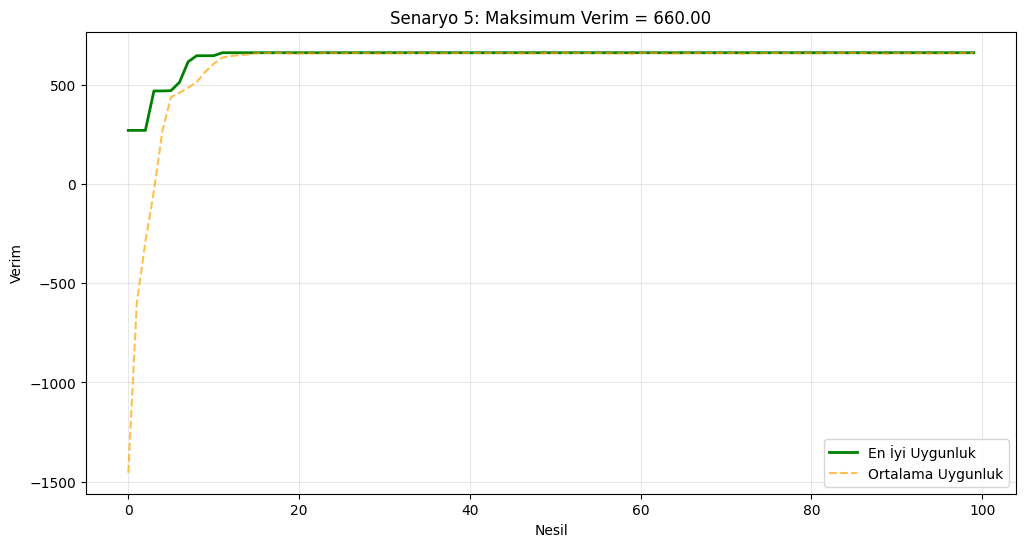

In [180]:
# 1. Başlagnıç Değişken Tanımlamaları
populasyon: Populasyon = populasyon_olustur(POPULASYON_BOYUTU, SINIRLAR)
en_iyi_gecmis: List[float] = []
ortalama_gecmis: List[float] = []

global_en_iyi_birey: Optional[Birey] = None
global_en_iyi_skor: float = -float('inf')

print(f"{'Nesil':<5} {'En İyi Fit':<15} {'Ortalama':<15} {'En İyi x1':<10} {'En İyi x2':<10}")
print("-" * 60)

# 2. Evrim Döngüsü
for nesil in range(1, NESIL_SAYISI+1):
    # A. Uygunluk Hesaplama
    uygunluk_skorlari: np.ndarray = uygunluk_hesapla(populasyon)

    # B. İstatistik ve Kayıt
    en_iyi_idx: int = int(np.argmax(uygunluk_skorlari))
    anlik_en_iyi_skor: float = float(uygunluk_skorlari[en_iyi_idx])
    anlik_ortalama: float = float(np.mean(uygunluk_skorlari))
    anlik_en_iyi_birey: Birey = populasyon[en_iyi_idx].copy()

    en_iyi_gecmis.append(anlik_en_iyi_skor)
    ortalama_gecmis.append(anlik_ortalama)

    # Global En İyiyi Güncelle
    if anlik_en_iyi_skor > global_en_iyi_skor:
        global_en_iyi_skor = anlik_en_iyi_skor
        global_en_iyi_birey = anlik_en_iyi_birey

    if nesil % 10 == 0 or nesil == NESIL_SAYISI:
        print(f"{nesil:<5} {anlik_en_iyi_skor:<15.2f} {anlik_ortalama:<15.2f} {anlik_en_iyi_birey[0]:<10.2f} {anlik_en_iyi_birey[1]:<10.2f}")

    # C. Elitizm
    sirali_indeksler = np.argsort(uygunluk_skorlari)[::-1]
    elitler: Populasyon = populasyon[sirali_indeksler[:ELITIZM_SAYISI]]

    # D. Seçim (Turnuva)
    ebeveynler: Populasyon = turnuva_secimi(populasyon, uygunluk_skorlari)

    # E. Çaprazlama ve Mutasyon
    yeni_nesil_listesi: List[Birey] = []

    for elit in elitler:
        yeni_nesil_listesi.append(elit)

    while len(yeni_nesil_listesi) < POPULASYON_BOYUTU:
        p1 = ebeveynler[np.random.randint(0, len(ebeveynler))]
        p2 = ebeveynler[np.random.randint(0, len(ebeveynler))]
        c1, c2 = caprazlama(p1, p2)
        yeni_nesil_listesi.append(mutasyon(c1, SINIRLAR))
        if len(yeni_nesil_listesi) < POPULASYON_BOYUTU:
            yeni_nesil_listesi.append(mutasyon(c2, SINIRLAR))

    populasyon = np.array(yeni_nesil_listesi)

# 3. Sonuçlar
print("\n" + "="*30)
print("OPTİMİZASYON SONU")
if global_en_iyi_birey is not None:
    print(f"Optimal x1 (Süre)   : {global_en_iyi_birey[0]:.4f} dk")
    print(f"Optimal x2 (Sıcaklık): {global_en_iyi_birey[1]:.4f} °C")
    print(f"Maksimum Verim (y)  : {global_en_iyi_skor:.4f}")

    # Doğrulama
    toplam = global_en_iyi_birey[0] + global_en_iyi_birey[1]
    durum = "BAŞARILI" if toplam <= 140 else "BAŞARISIZ"
    print(f"Kısıt Kontrolü      : {toplam:.2f} <= 140 ({durum})")
print("="*30)

plt.figure(figsize=(12, 6))
plt.plot(en_iyi_gecmis, label='En İyi Uygunluk', color='green', linewidth=2)
plt.plot(ortalama_gecmis, label='Ortalama Uygunluk', color='orange', linestyle='--', alpha=0.7)
plt.title(f'Maksimum Verim = {global_en_iyi_skor:.2f}')
plt.xlabel('Nesil')
plt.ylabel('Verim')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

Bulgular ve Tartışma

**1. Yakınsama Performansı**

Elde edilen yakınsama grafiği incelendiğinde, **"En İyi Uygunluk" (Yeşil Çizgi)** değerinin optimizasyonun hemen başında (ilk 5-10 nesil içerisinde) hızla yükseldiği görülmektedir. Algoritma, yaklaşık **10. nesilden itibaren** maksimum verim değeri olan **660.00** noktasına ulaşmış ve bu noktada kararlılık kazanmıştır.
* **Yorum:** Bu hızlı ve kararlı yakınsama, seçilen `POPULASYON_BOYUTU=50` ve `ELITIZM_SAYISI=2` parametrelerinin, çözüm uzayını taramak ve bulunan en iyi çözümü korumak için yeterli ve uygun olduğunu göstermektedir.

**2. Kısıtların Etkisi ve Başlangıç Koşulları**
Grafikteki **"Ortalama Uygunluk" (Turuncu Kesikli Çizgi)** değeri, 0. nesilde **-1400** seviyelerinde başlamaktadır.
* **Neden:** Rastgele başlatılan ilk popülasyondaki bireylerin büyük bir kısmı, $x_1 + x_2 \le 140$ kısıtını ihlal etmiştir.
* **Mekanizma:** Kodda uygulanan **"Ceza Fonksiyonu" (Penalty Function)**, bu uygunsuz bireyleri ağır şekilde cezalandırmış (fitness puanlarını düşürmüş) ve algoritmayı kısıtları sağlayan bölgelere yönlendirmiştir.
* **Sonuç:** İlerleyen nesillerde Turnuva Seçimi sayesinde "sağlıklı" bireylerin oranı artmış ve ortalama uygunluk değeri hızla pozitif seviyeye gelerek optimuma yaklaşmıştır.

**3. Matematiksel ve Teorik Doğrulama**
Algoritmanın bulduğu sonuç ($x_1=60, x_2=60$), problemin analitik çözümü ile birebir örtüşmektedir:
* **Zaman ($x_1$) Analizi:** Amaç fonksiyonunda $+x_1^2$ (karesel artış) terimi baskın olduğundan, algoritma reaksiyon süresini üst sınır olan **60 dakikaya** çekmiştir.
* **Sıcaklık ($x_2$) Analizi:** Fonksiyondaki $-x_1x_2$ terimi negatif etki yarattığı için, algoritma sıcaklığı ($x_2$) mümkün olan en düşük seviyede tutmaya çalışmıştır. Kısıtlar gereği ($x_2 \ge 60$) bu değer **60 °C** olarak belirlenmiştir.
* **Sağlama:**
    $$y = 8(60) + 3(60) - (60 \cdot 60) + (60^2)$$
    $$y = 480 + 180 - 3600 + 3600 = \mathbf{660}$$
* **Kısıt Kontrolü:** $60 + 60 = 120 \le 140$ (Kısıt başarıyla sağlanmıştır).

**Sonuç:** Geliştirilen Genetik Algoritma, kısıtları ihlal etmeden teorik olarak mümkün olan en yüksek verim değerine (Global Optimum) ulaşmayı başarmıştır.

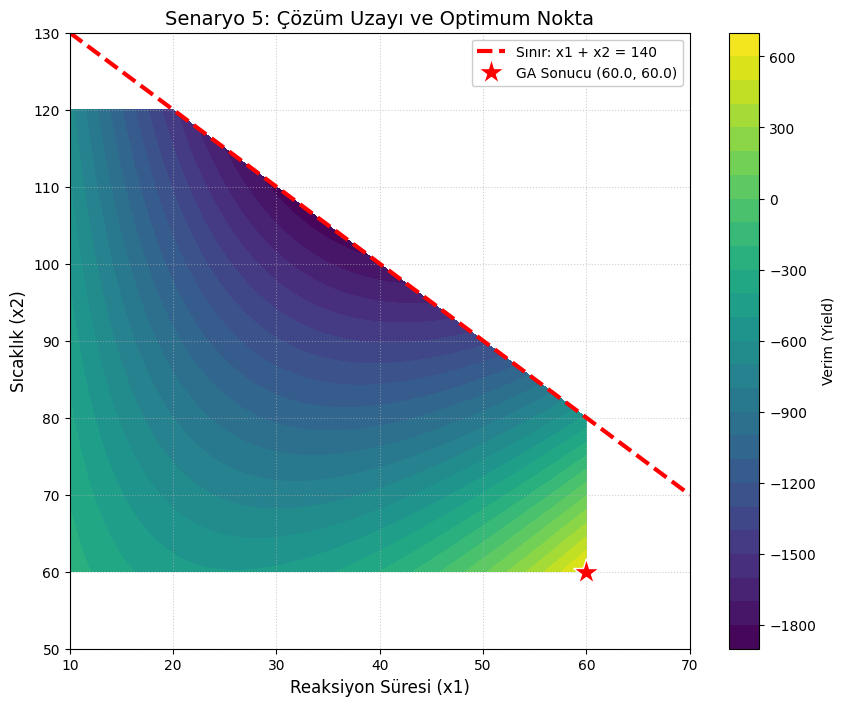

In [181]:
# --- 4. Görsel Doğrulama ---
# Bu grafik, matematiksel alanın tamamını tarar ve optimum noktanın
# gerçekten tepe noktası olduğunu görsel olarak kanıtlar.

# 1. Izgara (Meshgrid) Oluştur
x1_aralik = np.linspace(10, 70, 2000)  # Biraz geniş aralık (görmek için)
x2_aralik = np.linspace(50, 130, 2000)
X1, X2 = np.meshgrid(x1_aralik, x2_aralik)

# 2. Amaç Fonksiyonunu Hesapla (Z ekseni)
Z = (8 * X1) + (3 * X2) - (X1 * X2) + (X1**2)

# 3. Yasaklı Bölgeleri Maskele
# Kısıt 1: x1 + x2 > 140 (Yasak)
# Kısıt 2: Sınırlar (x1[10,60], x2[60,120])
yasak_bolge = (X1 + X2 > 140) | (X1 > 60) | (X1 < 10) | (X2 > 120) | (X2 < 60)

# Maskelenmiş Z verisi (Yasaklı bölgeler boş görünecek)
Z_masked = np.ma.array(Z, mask=yasak_bolge)

# 4. Çizim
plt.figure(figsize=(10, 8))

# Kontur Haritası (Heatmap)
# 'viridis' renk haritası: Sarı = Yüksek Verim, Mor = Düşük Verim
cp = plt.contourf(X1, X2, Z_masked, levels=25, cmap='viridis')
plt.colorbar(cp, label='Verim (Yield)')

# Kısıt Çizgisi (x1 + x2 = 140)
x_line = np.linspace(10, 70, 100)
y_line = 140 - x_line
plt.plot(x_line, y_line, 'r--', linewidth=3, label='Sınır: x1 + x2 = 140')

# Optimum Nokta (Genetik Algoritmanın Bulduğu)
if global_en_iyi_birey is not None:
    plt.plot(global_en_iyi_birey[0], global_en_iyi_birey[1], 'r*', markersize=20, markeredgecolor='white', label=f'GA Sonucu ({global_en_iyi_birey[0]}, {global_en_iyi_birey[1]})')

# Grafiği Süsle
plt.title('Senaryo 5: Çözüm Uzayı ve Optimum Nokta', fontsize=14)
plt.xlabel('Reaksiyon Süresi (x1)', fontsize=12)
plt.ylabel('Sıcaklık (x2)', fontsize=12)
plt.legend(loc='upper right', framealpha=1, facecolor='white')
plt.grid(True, linestyle=':', alpha=0.6)

# Alanı Odakla
plt.xlim(10, 70)
plt.ylim(50, 130)

plt.show()